Para mejorar la red, hemos hecho uso del transfer learning utilizando la red preentrenada Xception congelando las capas superiores. 

Con este cambio, ya vimos que obteníamos una mejora considerable como se puede observar en la gráfica al final de este documento.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#importamos la version de keras incluida en tensorflow
import tensorflow.keras as keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

In [2]:
#TEST GPU
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def get_available_gpus () :
    local_device_protos = device_lib.list_local_devices()
    return [x.name for  x in local_device_protos if x.device_type == 'GPU']

print ('Avaliable GPUS: ', get_available_gpus ())

Num GPUs Available:  1
Avaliable GPUS:  ['/device:GPU:0']


#  Model deployment

In [3]:
#Defining paths
TRAIN_PATH = "CovidDataset/Train"
VAL_PATH = "CovidDataset/Test"

In [4]:
#Training model
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [5]:
#Getting parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 128)     36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0

# Training data 

In [6]:
#Moulding train images
train_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)

test_dataset = image.ImageDataGenerator(rescale=1./255)

In [7]:
#Reshaping test and validation images 
train_generator = train_datagen.flow_from_directory(
    'CovidDataset/Train',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')
validation_generator = test_dataset.flow_from_directory(
    'CovidDataset/Val',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 224 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [8]:
%%time
epochs = 10
#Training the model
hist_new = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=2
)

Epoch 1/10
7/7 [==============================] - 15s 2s/step - loss: 1.3378 - accuracy: 0.4420 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.6506 - accuracy: 0.6384 - val_loss: 0.6369 - val_accuracy: 0.8667
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 0.5243 - accuracy: 0.7545 - val_loss: 0.4089 - val_accuracy: 0.9333
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 0.4301 - accuracy: 0.8125 - val_loss: 0.5097 - val_accuracy: 0.6333
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.3630 - accuracy: 0.8348 - val_loss: 0.2720 - val_accuracy: 0.9667
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.3369 - accuracy: 0.8661 - val_loss: 0.3052 - val_accuracy: 0.9833
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 0.2616 - accuracy: 0.9107 - val_loss: 0.1855 - val_accuracy: 0.9833
Epoch 8/10
7/7 [==================

### Local:
[1] Wall time: 1min 36s
[2] Wall time: 1min 36s
[3] Wall time: 1min 37s
[4] Wall time: 1min 36s
[5] Wall time: 1min 36s


### AWS:

### IBM Watson:


In [9]:
#Getting summary
summary=hist_new.history
print(summary)

{'loss': [1.3377587795257568, 0.6505592465400696, 0.524275004863739, 0.4300636649131775, 0.362976998090744, 0.3369317352771759, 0.26160934567451477, 0.19022367894649506, 0.15822632610797882, 0.15494363009929657], 'accuracy': [0.4419642984867096, 0.6383928656578064, 0.7544642686843872, 0.8125, 0.8348214030265808, 0.8660714030265808, 0.9107142686843872, 0.9330357313156128, 0.9553571343421936, 0.9598214030265808], 'val_loss': [0.6896392703056335, 0.6368646025657654, 0.4088778793811798, 0.5097258687019348, 0.27203622460365295, 0.30517902970314026, 0.18547607958316803, 0.1293802559375763, 0.06108005344867706, 0.08722782135009766], 'val_accuracy': [0.5, 0.8666666746139526, 0.9333333373069763, 0.6333333253860474, 0.9666666388511658, 0.9833333492279053, 0.9833333492279053, 0.9833333492279053, 0.9833333492279053, 0.9666666388511658]}


In [10]:
model.save("model_covid.h5")

In [11]:
model.evaluate(train_generator)

7/7 [==============================] - 8s 1s/step - loss: 0.1070 - accuracy: 0.9688


[0.10695428401231766, 0.96875]

In [12]:
print(model.evaluate(validation_generator))

2/2 [==============================] - 2s 825ms/step - loss: 0.0872 - accuracy: 0.9667
[0.08722782135009766, 0.9666666388511658]


## Confusion Matrix

In [13]:
import os
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [14]:
y_actual, y_test = [],[]

In [15]:
for i in os.listdir("./CovidDataset/Val/Normal/"):
    img=image.load_img("./CovidDataset/Val/Normal/"+i,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    predictions = model.predict(img)
    #print(predictions)
    y_test.append(predictions[0,0])
    y_actual.append(1)

print('y_test:\n', y_test)

y_test:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [16]:
for i in os.listdir("./CovidDataset/Val/Covid/"):
    img=image.load_img("./CovidDataset/Val/Covid/"+i,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    #print(predictions)
    predictions = model.predict(img)
    y_test.append(predictions[0,0])
    y_actual.append(0)
    
print('y_test:\n', y_test)

y_test:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [17]:
y_actual=np.array(y_actual)
y_test=np.array(y_test)

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cn=confusion_matrix(y_actual.astype(int),y_test.astype(int))

<AxesSubplot:>

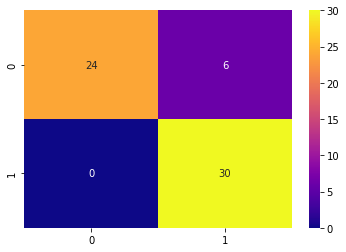

In [19]:
sns.heatmap(cn,cmap="plasma",annot=True) #0: Covid ; 1: Normal

### Transfer learning uso de red entrenada Xception:


In [20]:
#Descargamos el modelo pre-entrenado Xception y lo asignamos a base model
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

#Operación de agrupación promedio global para datos espaciales.
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

#salida
output = keras.layers.Dense(2, activation="softmax")(avg)

#modelo
xception_model = keras.models.Model(inputs=base_model.input, outputs=output)

In [21]:
#al principio del entrenamiento congelamos los pesos de las capas preentrenadas al principio del entrenamiento
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
xception_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history2 = xception_model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10, validation_steps=2)

Epoch 1/10
7/7 [==============================] - 14s 2s/step - loss: 0.1791 - accuracy: 0.9420 - val_loss: 0.0480 - val_accuracy: 0.9667
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.1381 - accuracy: 0.9821 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 0.0321 - accuracy: 0.9866 - val_loss: 0.0713 - val_accuracy: 0.9833
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 0.0842 - accuracy: 0.9821 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.0824 - accuracy: 0.9955 - val_loss: 0.0260 - val_accuracy: 0.9833
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.1616 - accuracy: 0.9911 - val_loss: 0.0909 - val_accuracy: 0.9667
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 0.0960 - accuracy: 0.9955 - val_loss: 0.1509 - val_accuracy: 0.9667
Epoch 8/10
7/7 [==================

Aqui habiamos probado a continuar el entrenamiento descongelando las capas que habíamos congelado previamente, pero los resultados obtenidos eran peores, por lo que eliminamos la celda del notebook

<Figure size 432x288 with 0 Axes>

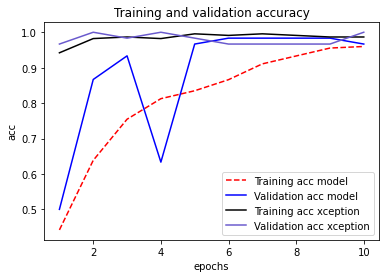

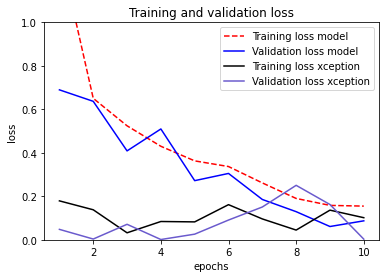

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt

acc      = hist_new.history['accuracy']
val_acc  = hist_new.history['val_accuracy']
loss     = hist_new.history['loss']
val_loss = hist_new.history['val_loss' ]

acc2      = history2.history['accuracy']
val_acc2  = history2.history['val_accuracy']
loss2     = history2.history['loss']
val_loss2 = history2.history['val_loss' ]


epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc model'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc model')

plt.plot  ( epochs,     acc2, 'black', label='Training acc xception'  )
plt.plot  ( epochs, val_acc2,  'slateblue', label='Validation acc xception')

plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot  ( epochs,     loss, 'r--', label='Training loss model' )
plt.plot  ( epochs, val_loss ,  'b', label='Validation loss model' )

plt.plot  ( epochs,     loss2, 'black', label='Training loss xception'  )
plt.plot  ( epochs, val_loss2,  'slateblue', label='Validation loss xception')


plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
plt.ylim(0,1)

plt.legend()
plt.figure()